In [5]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

from imports import *
import numpy as np
import h5py
import json
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import signal
from scipy import stats
from target import build_tgt_matrix
import pandas as pd
from loading import load_session_data
from Behavior.behavior import get_behav_units
from session.sessions import selected_009266, selected_009265, selected_008229

%matplotlib inline

In [6]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [33]:
sessions = [s for s in selected_008229.keys()]
sessions = [s for s in selected_009266.keys()]
sessions.sort()
sessions

['009266_hippoSIT_2023-04-13_08-57-46',
 '009266_hippoSIT_2023-04-14_09-17-34',
 '009266_hippoSIT_2023-04-17_09-06-10',
 '009266_hippoSIT_2023-04-17_17-04-17',
 '009266_hippoSIT_2023-04-18_10-10-37',
 '009266_hippoSIT_2023-04-18_17-03-10',
 '009266_hippoSIT_2023-04-19_10-33-51',
 '009266_hippoSIT_2023-04-20_08-57-39',
 '009266_hippoSIT_2023-04-20_15-24-14',
 '009266_hippoSIT_2023-04-21_08-43-00',
 '009266_hippoSIT_2023-04-21_13-12-31',
 '009266_hippoSIT_2023-04-24_10-08-11',
 '009266_hippoSIT_2023-04-24_16-56-55',
 '009266_hippoSIT_2023-04-26_08-20-17',
 '009266_hippoSIT_2023-05-02_12-22-14',
 '009266_hippoSIT_2023-05-04_09-11-06',
 '009266_hippoSIT_2023-05-04_19-47-15',
 '009266_hippoSIT_2023-05-22_09-27-22',
 '009266_hippoSIT_2023-05-23_09-18-05',
 '009266_hippoSIT_2023-05-25_15-55-57',
 '009266_hippoSIT_2023-06-14_08-21-23',
 '009266_hippoSIT_2023-06-19_08-58-35']

## Higher firing before success?

In [41]:
def get_FR_TGT_score(i_rate, tl_idxs, labels, offset=3):
    # offset in seconds
    # tl_idxs to i_rate, sampled 100Hz
    # labels for each index
    scores = np.zeros(len(tl_idxs))
    for i, tl_idx in enumerate(tl_idxs):
        mean = i_rate.mean()
        all_low  = (i_rate[tl_idx - offset*100:tl_idx] < mean).all()  # 100Hz sampling
        all_high = (i_rate[tl_idx - offset*100:tl_idx] > mean).all()  # 100Hz sampling
        #all_low  = i_rate[tl_idx - offset*100:tl_idx].mean() < mean
        #all_high = i_rate[tl_idx - offset*100:tl_idx].mean() > mean
        if (labels[i] == 0 and all_low) or (labels[i] == 1 and all_high):
            scores[i] = 1
            
    return scores

In [37]:
session = sessions[7]
session

'009266_hippoSIT_2023-04-20_08-57-39'

In [38]:
session_data = load_session_data(session)

tl           = session_data['tl']
tgt_matrix   = session_data['tgt_matrix']
single_units = session_data['single_units']

behav_units = get_behav_units(session)
len(behav_units)

8

In [39]:
offset = 3
iter_count = 100
all_idxs   = np.arange(len(tl) - 2*100*offset) + 100*offset

unit_mx = np.zeros([len(behav_units), 4])  # real score, shuffled mean, 95 perc, 5 perc
for i, unit_name in enumerate(behav_units):
    i_rate  = single_units[unit_name]
    tl_idxs = tgt_matrix[:, 0]
    labels  = tgt_matrix[:, 4]
    score = get_FR_TGT_score(i_rate, tl_idxs, labels, offset=3).mean()
    
    scores_shuf = np.zeros(iter_count)
    for j in range(iter_count):
        tl_idxs = np.random.choice(all_idxs, len(tgt_matrix))
        #labels_rand = labels.copy()
        #np.random.shuffle(labels_rand)
        scores_shuf[j] = get_FR_TGT_score(i_rate, tl_idxs, labels, offset=offset).mean()
        
    perc_high = np.percentile(scores_shuf, 95)
    perc_low  = np.percentile(scores_shuf, 5)
    unit_mx[i] = np.array([score, scores_shuf.mean(), perc_high, perc_low])
    print(unit_name + '; ', end='')

2-2; 2-3; 3-15; 3-16; 3-4; 4-8; 4-9; 5-6; 

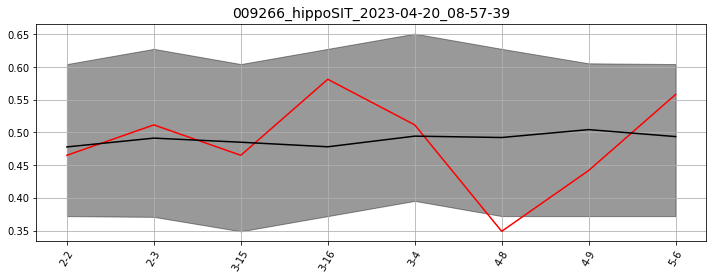

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

ax.plot(unit_mx[:, 0], color='red')
ax.plot(unit_mx[:, 1], color='black')
ax.fill_between(np.arange(len(behav_units)), unit_mx[:, 3], unit_mx[:, 2], color='black', alpha=0.4)
ax.set_xticks(np.arange(len(behav_units)))
ax.set_xticklabels(behav_units, rotation=60)
ax.set_title(session, fontsize='14')
ax.grid()

## Increase FR in TGT SUCCESS, not in TGT MISS, and drop FR after success

In [42]:
# TODO